In [1]:
#MOUNT GOOGLE DRIVE
#if your datasets are not stored in gdrive, skip this
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#IMPORT REQUIRED LIBRARIES
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd

In [5]:
#EDIT: SPECIFY INPUT IMAGE NUMBER FOR LATER NAMING
imgNum = "2" #edit this to specify number of original image that you want to label
imgPath = 'gdrive/MyDrive/YOLOShared/Original/' + imgNum + ".png"

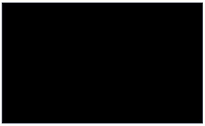

In [6]:
#SHOW IMAGE
imgArray = cv2.imread(imgPath)
cv2.imwrite('gdrive/MyDrive/YOLOShared/Export/image' + imgNum + '.jpg',imgArray) #save raw img to new extension and folder after reading it in
imgArraycp = cv2.imread(imgPath)
img = cv2_imshow(imgArray)

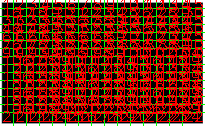

In [7]:
#CREATE A GRID ABOVE IMAGE
height,width,channels = imgArray.shape

# Define the number of rows and columns for the grid
num_rows, num_cols = 15, 15

# Calculate the spacing between grid lines
row_spacing = height // num_rows
col_spacing = width // num_cols

# Draw the grid lines on the image
for i in range(1, num_rows):
    y = i * row_spacing
    cv2.line(imgArray, (0, y), (width, y), (0, 255, 0), 1)

for j in range(1, num_cols):
    x = j * col_spacing
    cv2.line(imgArray, (x, 0), (x, height), (0, 255, 0), 1)

# Label each grid cell in ascending order from top left to bottom right
label = 1
for i in range(num_rows):
    for j in range(num_cols):
        x_center = j * col_spacing + col_spacing // 2
        y_center = i * row_spacing + row_spacing // 2
        cv2.putText(imgArray, str(label), (x_center - 5, y_center + 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        label += 1

# Display the image with the grid overlay
cv2_imshow(imgArray)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [8]:
#EDIT: Specify where to label
grid_start = np.array([10,10,92,139,151,184,197])
grid_end = np.array([73,134,108,155,182,201,213])
label=['dam','nest']
diff = len(grid_start) - len(label)
for i in range(0,diff):
  label.append('pups')

In [9]:
#USE GRID TO CREATE BOUNDING BOXES
def annotate_with_bbox(labels, grid_starts, grid_ends):
    global yolo
    yolo = []
    for label, grid_start, grid_end in zip(labels, grid_starts, grid_ends):
        # Ensure the grid numbers are within valid range
        grid_start = max(0, min(grid_start, num_rows * num_cols - 1)) -1
        grid_end = max(0, min(grid_end, num_rows * num_cols - 1)) -1

        # Calculate the row and column indices from the grid numbers
        start_row, start_col = divmod(grid_start, num_cols)
        end_row, end_col = divmod(grid_end, num_cols)

        # Convert grid indices to pixel coordinates
        top_left_x = start_col * col_spacing
        top_left_y = start_row * row_spacing
        bottom_right_x = (end_col + 1) * col_spacing
        bottom_right_y = (end_row + 1) * row_spacing

        # Draw bounding box and label on the image
        cv2.rectangle(imgArraycp, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), (255, 0, 0), 2)
        text = f'{label}'
        cv2.putText(imgArraycp, text, (top_left_x, top_left_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        # Convert to YOLO coordinates
        image_width, image_height = width, height
        center_x = (top_left_x + bottom_right_x) / (2 * image_width)
        center_y = (top_left_y + bottom_right_y) / (2 * image_height)
        bbox_width = (bottom_right_x - top_left_x) / image_width
        bbox_height = (bottom_right_y - top_left_y) / image_height
        yolo.append([label,center_x,center_y,bbox_width,bbox_height])
  # Display the image with the bounding boxes and labels
    cv2_imshow(imgArraycp)
    cv2.imwrite('gdrive/MyDrive/YOLOShared/BoundingBoxes/image' + imgNum + '.jpg',imgArraycp) #save raw img to new extension and folder after reading it in
    cv2.waitKey(0)
    cv2.destroyAllWindows()

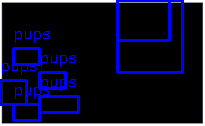

In [10]:
annotate_with_bbox(label,grid_start,grid_end)

In [11]:
#EXPORT BOUNDING BOX INFO
yolo = pd.DataFrame(yolo)
yolo = yolo.replace('dam','0')
yolo = yolo.replace('pup','1')
#yolo #view yolo format
yolo.to_csv('gdrive/MyDrive/YOLOShared/YOLOreadable/image' + imgNum + '.txt', sep='\t', index=False,header=False) #save .txt

TO EXPORT BOUNDING BOX TO YOLO, YOU NEED TO EXPORT:
1) an image file ex: 'image1.jpg'
2) a corresponding .txt file with the same name ex: 'image1.txt'.
- The .txt file should have a new row for each class, where class names are indices and values across rows contain info about box. For example:
0 0.5 0.5 0.7 0.3
1 0.3 0.2 0.4 0.4
1 0.2 0.3 0.8 0.2
Where row 1 is class dam (the 0) with a bounding box with location at the image center (0.5,0.5) with box height 0.7 and width 0.3 (both relative to image size)
Rows 2 and 3 are are class 1, which in this case is pups
